In [1]:
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.wcs import WCS
# specutils packages
from specutils import Spectrum1D
from specutils.analysis import line_flux
from specutils.fitting import fit_generic_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from specutils.analysis import centroid
from specutils.analysis import moment
import warnings
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f85b23d2550>

In [19]:
# OUR PN
hdu = fits.open("../Spectra-lamostdr7/spec-56581-VB031N50V1_sp08-218.fits")
hdudata = hdu[0].data
wl = hdudata[2]
Flux = hdudata[0]

In [20]:
# Defining units astropy
rel_flux = u.def_unit('Relative~flux')
rel_flux.decompose()

Unit("Relative~flux")

Re-format this dataset into astropy quantities

In [21]:
lamb = wl * u.AA 
flux = Flux * rel_flux
spec = Spectrum1D(spectral_axis=lamb, flux=flux) 

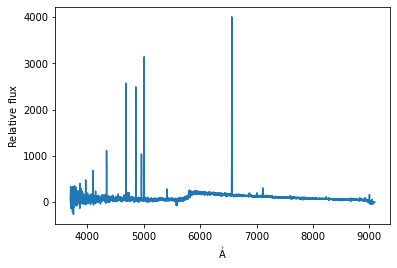

In [22]:
f, ax = plt.subplots()  
ax.step(spec.spectral_axis, spec.flux) 

**Now maybe you want the equivalent width of a spectral line. That requires normalizing by a continuum estimate:**

In [23]:
cont_norm_spec = spec / fit_generic_continuum(spec)(spec.spectral_axis) 

(6539.999999999999, 6569.999999999999)

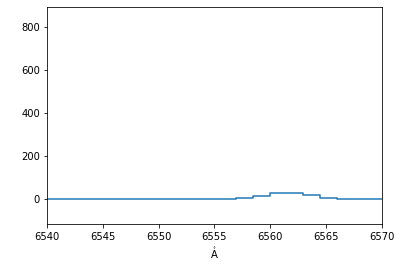

In [24]:
f, ax = plt.subplots()  
ax.step(cont_norm_spec.wavelength, cont_norm_spec.flux)  
ax.set_xlim(654 * u.nm, 657 * u.nm)  

In [25]:
equivalent_width(cont_norm_spec, regions=SpectralRegion(6556 * u.AA,  6569* u.AA)) 

<Quantity -142.27065999 Angstrom>

### Line Flux Estimates

In [26]:
line_flux(spec, regions=SpectralRegion(6556 * u.AA,  6569* u.AA))  

<Quantity 21404.36737107 Angstrom Relative~flux>

In [27]:
centroid(spec, regions=SpectralRegion(6556 * u.AA,  6569* u.AA))  

<Quantity 6562.2637 Angstrom>

# Line/Spectrum Fitting

## Parameter Estimation

In [34]:
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from astropy.modeling import models

In [35]:
sub_region = SpectralRegion(6556 * u.AA,  6569* u.AA)
sub_spectrum = extract_region(spec, sub_region)

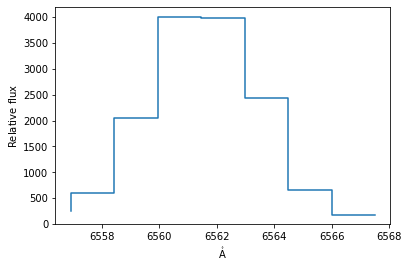

In [36]:
f, ax = plt.subplots()  
ax.step(sub_spectrum.spectral_axis, sub_spectrum.flux) 

In [37]:
print(estimate_line_parameters(sub_spectrum, models.Gaussian1D())) 

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude          mean            stddev      
     Relative~flux      Angstrom         Angstrom     
    ---------------- -------------- ------------------
    4004.78369140625 6562.263671875 2.0181450843811035


If an Model is used that does not have the predefined parameter estimators, or if one wants to use different parameter estimators then one can create a dictionary where the key is the parameter name and the value is a function that operates on a spectrum (lambda functions are very useful for this purpose). For example if one wants to estimate the line parameters of a line fit for a RickerWavelet1D one can define the estimators dictionary and use it to populate the estimator attribute of the model’s parameters:

## Model (Line) Fitting

In [43]:
from specutils.fitting import fit_lines
# Fit the spectrum and calculate the fitted flux values (``y_fit``)
g_init= models.Gaussian1D(amplitude=4004.78369140625 * rel_flux, mean=6562.263671875*u.AA, stddev=2.0181450843811035 * u.AA)
g_fit = fit_lines(spec, g_init, window=(6556 * u.AA,  6569* u.AA))
y_fit = g_fit(lamb)

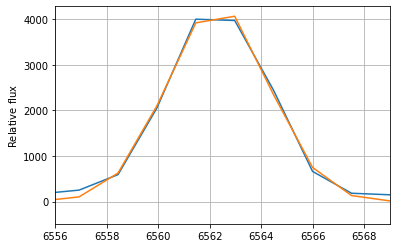

In [51]:
plt.plot(wl, Flux)
plt.plot(wl, y_fit)
plt.xlim(6556,  6569)
#plt.title('Single fit peak window')
plt.grid(True)

### Integrating over the Gaussian

In [64]:
gauss = Spectrum1D(spectral_axis=lamb, flux=y_fit) 
sub_gauss = extract_region(gauss, sub_region)


(6556.0, 6569.0)

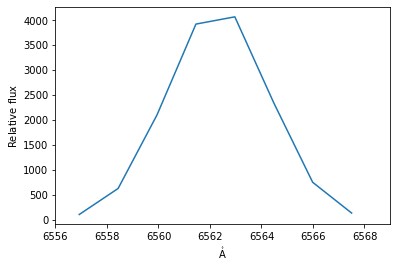

In [67]:
f, ax = plt.subplots()  
ax.plot(sub_gauss.spectral_axis, sub_gauss.flux) 
plt.xlim(6556,  6569)

In [69]:
 flux_line = np.trapz(sub_gauss.flux, sub_gauss.spectral_axis) 

In [70]:
 flux_line

<Quantity 21051.95099973 Angstrom Relative~flux>